# Projet 5 - Segmentez des clients d'un site e-commerce - exploration de différents modèles de clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from math import pi

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from custom_library.outils import prepare_compute_evaluate_kmeans, prepare_compute_evaluate_dbscan

## Importation des données nettoyées

In [4]:
with open("clean_dataset.csv","rb") as f:
	data = pl.read_csv(f)

In [5]:
data.shape

(95082, 26)

## Diviser en 4 différents jeux de données : 
- données RFM i.e. qui contiennent seulement les variables de récence ("recence"), de fréquence ("nb_commandes") et de montant ("depense_totale")
- données numériques i.e. qui contiennent seulement les variables numériques, et pas les variables catégorielles encodées
- données totales
- données numériques sans récence car elle n'a pas beaucoup de sens pour notre jeu de données sachant que 96% des clients n'ont passé qu'une seule commande. 

In [6]:
data.columns

['customer_unique_id',
 'nb_commandes',
 'nb_produits',
 'depense_totale',
 'recence',
 'score_moyen',
 'customer_region_Centre-Ouest',
 'customer_region_Nord',
 'customer_region_Nord-Est',
 'customer_region_Sud',
 'customer_region_Sud-Est',
 'grand_type_produit_prefere_Alimentation & Boissons',
 'grand_type_produit_prefere_Animaux',
 'grand_type_produit_prefere_Auto & Transport',
 'grand_type_produit_prefere_Autres',
 'grand_type_produit_prefere_Bricolage & Jardin',
 'grand_type_produit_prefere_Bébé & Enfants',
 'grand_type_produit_prefere_Cuisine & Accessoires décoratifs',
 'grand_type_produit_prefere_Loisirs & Culture',
 'grand_type_produit_prefere_Mobilier & Aménagement intérieur',
 'grand_type_produit_prefere_Mode & Accessoires',
 'grand_type_produit_prefere_Papeterie & Bureau',
 'grand_type_produit_prefere_Santé & Beauté',
 'grand_type_produit_prefere_null',
 'grand_type_produit_prefere_Électroménager',
 'grand_type_produit_prefere_Électronique & Informatique']

In [7]:
data = data.drop('customer_unique_id')

print(f"Avant d'enlever les valeurs manquantes, le dataset contenait {len(data)} clients")

data_RFM = data[['recence','nb_commandes','depense_totale']]
data_RFM= data_RFM.drop_nulls()
print(f"Après avoir enlevé les valeurs manquantes du dataset data_RFM, il reste {len(data_RFM)} clients")

data_numeric = data[:,:5]
data_numeric = data_numeric.drop_nulls()
print(f"Après avoir enlevé les valeurs manquantes du dataset data_numeric, il reste {len(data_numeric)} clients")

data_num_WO_recency = data_numeric.drop('recence')
print(f"Après avoir enlevé les valeurs manquantes du dataset data_num_WO_recency, il reste {len(data_num_WO_recency)} clients")

data_tot = data
data_tot= data_tot.drop_nulls()
print(f"Après avoir enlevé les valeurs manquantes du dataset data_tot, il reste {len(data_tot)} clients")

datasets_list = [data_RFM,data_numeric,data_num_WO_recency,data_tot]
datasets_descriptions = ["Variables RFM seules", "Variables numériques seules", "Variables numériques sans la variables récence", "Variables numériques et catégorielles encodées"]

Avant d'enlever les valeurs manquantes, le dataset contenait 95082 clients
Après avoir enlevé les valeurs manquantes du dataset data_RFM, il reste 95082 clients
Après avoir enlevé les valeurs manquantes du dataset data_numeric, il reste 94385 clients
Après avoir enlevé les valeurs manquantes du dataset data_num_WO_recency, il reste 94385 clients
Après avoir enlevé les valeurs manquantes du dataset data_tot, il reste 94385 clients


## Méthode du Kmeans

K-Means est un algorithme de **clustering** non supervisé qui cherche à partitionner les données en `k` groupes (ou "clusters") en minimisant la **variance intra-cluster**. Le processus se déroule en plusieurs étapes :

1. Initialisation de `k` centroïdes (aléatoirement ou par méthode heuristique).
2. Attribution de chaque point au centroïde le plus proche (selon la distance euclidienne).
3. Recalcul des centroïdes comme moyenne des points de chaque cluster.
4. Répétition des étapes 2 et 3 jusqu’à convergence (peu ou pas de changement dans les centroïdes).

Plusieurs **métriques** permettent d’évaluer la qualité du regroupement et d’aider à choisir un `k` pertinent :

1. L'inertie
- Mesure la variance intracluster
- Inertie minimale est signe de clusters denses

2. Méthode du coude (Elbow method)
- Repose sur la mesure de la **somme des distances au carré** entre les points et leur centroïde (inertie intra-cluster).
- On trace l'inertie en fonction de `k`. Le **"coude"** sur la courbe indique un bon compromis entre complexité du modèle et performance.

3. Coefficient de silhouette
- Mesure la **similarité d’un point avec son propre cluster** comparée à celui le plus proche.
- Le score varie entre -1 (mauvais regroupement) et 1 (regroupement optimal).
- Une moyenne élevée indique que les clusters sont bien séparés et denses.

4. Indice de Davies-Bouldin
- Évalue la **compacité et la séparation** des clusters.
- Repose sur le ratio entre l’étalement intra-cluster et la distance inter-cluster --> plus l’indice est **faible**, meilleure est la qualité du regroupement.



In [ ]:
for idx in range(len(datasets_list)):
	prepare_compute_evaluate_kmeans(datasets_list[idx], datasets_descriptions[idx], max_num_clusters = 8, random_state = 1)

La présence ou non de la variable récence dans le dataset composé des variables numériques seules n'a pas d'impact sur les résultats du kmeans. <br> L'ajout des variables encodées détériore fortement les résultats du kmeans. 
Le KMeans se base sur des distances euclidiennes, qui supposent une continuité et une échelle comparable entre les variables.
L’ajout de variables catégorielles encodées en one-hot peut déséquilibrer les distances :
- chaque catégorie introduit une nouvelle dimension binaire, ce qui augmente artificiellement l'influence de cette variable.
- cela peut déformer l’espace de distances et dégrader fortement la qualité des clusters.
Une solution pourrait être de changer la façon de calculer les distances en utilisant des équivalents au kmeans basées sur d'autres types de distances par exemple distance de manhattan. 

In [ ]:
k_choisi = 4
data_chosen = data_numeric.to_numpy()

In [ ]:
# Application finale du K-means avec le K choisi
	# Préparation des données
pt = PowerTransformer(method="yeo-johnson", standardize = True)
X_transformed = pt.fit_transform(data_chosen)
final_kmeans = KMeans(n_clusters=k_choisi, random_state=42)
final_clusters = final_kmeans.fit_predict(X_transformed)

# Affichage des scores finaux
print(f"\nScores pour K = {k_choisi}:")
print(f"Inertie: {final_kmeans.inertia_}")
print(f"Score Silhouette: {silhouette_score(X_transformed, final_clusters)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_transformed, final_clusters)}")

- data_numeric, random state = 42 : <br> 
Scores pour K = 4:
    - Inertie: 79114.74181976692
    - Score Silhouette: 0.4485005102704839
    - Davies-Bouldin Index: 0.7360699869869303

<!-- - data_numeric, random state = 12 : <br>
Scores pour K = 4:
	- Inertie: 79114.54283500843
	- Score Silhouette: 0.4484665986665208
	- Davies-Bouldin Index: 0.7360158793413563

--> le modèle est assez stable -->

- data_RFM, random_state = 42: <br>
Scores pour K = 4:
	- Inertie: 10403
	- Score Silhouette: 0.54
	- Davies-Bouldin Index: 0.54

## Comparer les profils moyens des clusters sur chaque variable.

In [ ]:
# Centroïdes (dans l'espace standardisé si KMeans a été fait sur les données standardisées)
centroids = pd.DataFrame(final_kmeans.cluster_centers_, columns=data_chosen.columns)

# Barplot par cluster
centroids.T.plot(kind="bar", figsize=(12, 6))
plt.title("Centroïdes des clusters (standardisés)")
plt.ylabel("Valeur moyenne par cluster")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha='right') 
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
sns.heatmap(centroids.T, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap des centroïdes")
plt.ylabel("Variables")
plt.xlabel("Clusters")
plt.show()

## Visualiser le profil complet de chaque cluster sur un cercle

In [ ]:
def plot_radar(centroids_df, data_orig_df, labels):
    # Calcul des moyennes originales par cluster
    original_means = data_orig_df.copy()
    original_means["cluster"] = labels
    original_means = original_means.groupby("cluster").median()

    categories = centroids_df.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))

    for idx, row in centroids_df.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f"Cluster {idx}")

        # Afficher les vraies moyennes en annotation
        for j, var in enumerate(categories):
            angle = angles[j]
            radius = row[var]
            orig_val = original_means.loc[idx, var]
            offset = 0.05 if radius >= 0 else -0.05
            plt.text(
                angle,
                radius + offset,
                f"{orig_val:.2f}",
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )
        print(idx)

    plt.xticks(angles[:-1], categories, color="grey", size=12)
    plt.title("Radar des centroïdes (standardisés)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


plot_radar(centroids_df=centroids, data_orig_df=data_chosen, labels=final_clusters)


#### data_RFM :
Les 4 clusters se distinguent seulement par leur dépense totale moyenne

#### data_numeric : 

- Cluster 0 : clients satisfaits, qui achètent peu mais des produits chers
- Cluster 1 : dépensiers moyens mais particulièrement insatisfaits
- Cluster 2 : parmi les plus dépensiers, qui achètent beaucoup de produits pas chers. Leur satisfaction est plutot moyenne
- Cluster 3 : clients économes et satisfaits


#### Conclusion 
La division en clusters à partir de data_numeric semble avoir plus de sens et porter plus d'informations métier que pour data_RFM. Malgré ses scores moindre, on choisit donc le dataset_numeric

## Comparer la distribution de chaque variable selon le cluster

In [ ]:
data_chosen["cluster"] = final_kmeans.labels_

# Pour chaque variable quantitative
for col in data_chosen.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="cluster", y=col, data=data_chosen)
    plt.title(f"Distribution de {col} par cluster")
    plt.show()


## Visualiser les clusters en 2D grâce à une ACP

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_transformed)
pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["cluster"] = final_kmeans.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("ACP - Visualisation des clusters")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.legend(title="Cluster")
plt.show()


# DBSCAN 

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering basé sur la densité.
Il regroupe les points densément connectés et identifie les points isolés comme du bruit --> le nombre de clusters n'est pas un paramètre, il émerge naturellement
Il nécessite deux paramètres :
- eps : la distance maximale entre deux points pour qu'ils soient considérés comme voisins.
- min_samples : le nombre minimum de points pour former un noyau dense (core point).

Fonctionnement :
1. Pour chaque point, DBSCAN récupère ses voisins dans un rayon eps.
2. Si le point a au moins 'min_samples' voisins, il devient un point noyau et forme un cluster.
3. Les voisins directs et indirects (par transitivité) sont ajoutés au cluster.
4. Les points trop isolés (pas assez de voisins) sont marqués comme bruit.
Avantages : détecte des clusters de forme arbitraire et gère bien le bruit.
Inconvénients : sensible au choix des paramètres et moins performant lorsque les densités sont très variables.

D'après [cette source](https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143), la valeur optimale de min_samples est 2xnb_features ici et la valeur optimale de eps est définie par un coude dans la courbe du classement croissant des distances des K plus proches voisins (K = 2xnb_features-1) : les distances augmentent d'un coup pour les points correspondant à du bruit. Le code ci-dessous permet de tracer cette courbe et de définir eps : 

Pour des raisons de gestions de mémoire, il faut dans un premier temps réduire le nombre de lignes. Pour cela, j'utilise un kmeans préliminaire. 

In [18]:
#data_numeric
pt = PowerTransformer(method="yeo-johnson", standardize = True)
data_to_transform = data_numeric.to_numpy()
X_transformed = pt.fit_transform(data_to_transform)
preliminary_kmeans_numeric = KMeans(n_clusters=20_000, random_state=42)
preliminary_kmeans_numeric.fit_predict(X_transformed)
data_numeric_reduced = pl.DataFrame(
    preliminary_kmeans_numeric.cluster_centers_, schema=data_numeric.columns
)
data_numeric_reduced.head()

nb_commandes,nb_produits,depense_totale,recence,score_moyen
f64,f64,f64,f64,f64
-3.4694e-18,-0.376386,0.322192,3.3330e-14,0.788971
-3.4694e-18,-0.376386,0.333249,3.2486e-14,-1.255885
-3.4694e-18,2.655521,0.462171,5.7232e-14,-0.483097
-3.4694e-18,-0.376386,-1.29429,-2.6736e-13,0.788971
-3.4694e-18,-0.376386,-1.836887,1.1704e-13,-1.255885


In [ ]:
#data_tot
pt = PowerTransformer(method="yeo-johnson", standardize = True)
data_to_transform = data_tot.to_numpy()
X_transformed = pt.fit_transform(data_to_transform)
preliminary_kmeans_datatot = KMeans(n_clusters=20_000, random_state=42)
preliminary_kmeans_datatot.fit_predict(X_transformed)
data_tot_reduced = pl.DataFrame(
    preliminary_kmeans_datatot.cluster_centers_, schema=data_tot.columns
)
data_tot_reduced.head()

nb_commandes,nb_produits,depense_totale,recence,score_moyen,customer_region_Centre-Ouest,customer_region_Nord,customer_region_Nord-Est,customer_region_Sud,customer_region_Sud-Est,grand_type_produit_prefere_Alimentation & Boissons,grand_type_produit_prefere_Animaux,grand_type_produit_prefere_Auto & Transport,grand_type_produit_prefere_Autres,grand_type_produit_prefere_Bricolage & Jardin,grand_type_produit_prefere_Bébé & Enfants,grand_type_produit_prefere_Cuisine & Accessoires décoratifs,grand_type_produit_prefere_Loisirs & Culture,grand_type_produit_prefere_Mobilier & Aménagement intérieur,grand_type_produit_prefere_Mode & Accessoires,grand_type_produit_prefere_Papeterie & Bureau,grand_type_produit_prefere_Santé & Beauté,grand_type_produit_prefere_null,grand_type_produit_prefere_Électroménager,grand_type_produit_prefere_Électronique & Informatique
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-3.4694e-18,-0.376386,0.323171,1.0961e-13,0.788971,-0.24892,-0.137925,-0.323923,2.451035,-1.47575,-0.099485,-0.132688,-0.204113,-0.060216,-0.229767,-0.272091,-0.426856,2.558509,-0.418307,-0.187998,-0.171442,-0.372653,-0.120732,-0.140378,-0.430458
-3.4694e-18,-0.376386,-0.158444,-6.0350e-14,0.788971,-0.24892,-0.137925,-0.323923,-0.407991,0.677621,-0.099485,-0.132688,-0.204113,-0.060216,-0.229767,-0.272091,-0.426856,-0.390853,-0.418307,-0.187998,-0.171442,-0.372653,-0.120732,-0.140378,2.323105
-3.4694e-18,-0.376386,-0.181785,-7.4579e-14,-0.483097,-0.24892,-0.137925,-0.323923,-0.407991,0.677621,-0.099485,-0.132688,-0.204113,-0.060216,-0.229767,-0.272091,-0.426856,-0.390853,2.390591,-0.187998,-0.171442,-0.372653,-0.120732,-0.140378,-0.430458
-3.4694e-18,-0.376386,0.91257,1.0902e-13,-1.670618,-0.24892,-0.137925,-0.323923,-0.407991,0.677621,-0.099485,-0.132688,-0.204113,-0.060216,-0.229767,-0.272091,2.342708,-0.390853,-0.418307,-0.187998,-0.171442,-0.372653,-0.120732,-0.140378,-0.430458
-3.4694e-18,-0.376386,-0.934505,6.5474e-14,0.788971,-0.24892,-0.137925,-0.323923,-0.407991,0.677621,-0.099485,-0.132688,-0.204113,-0.060216,-0.229767,3.675238,-0.426856,-0.390853,-0.418307,-0.187998,-0.171442,-0.372653,-0.120732,-0.140378,-0.430458


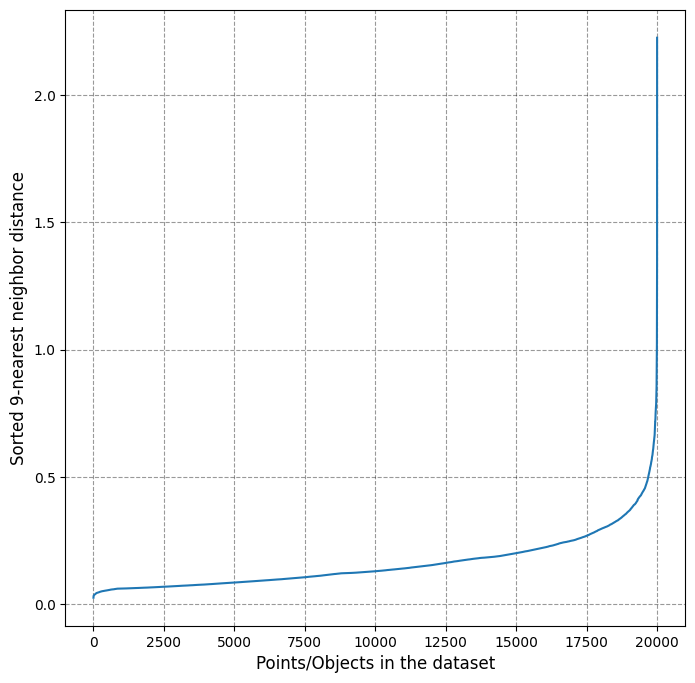

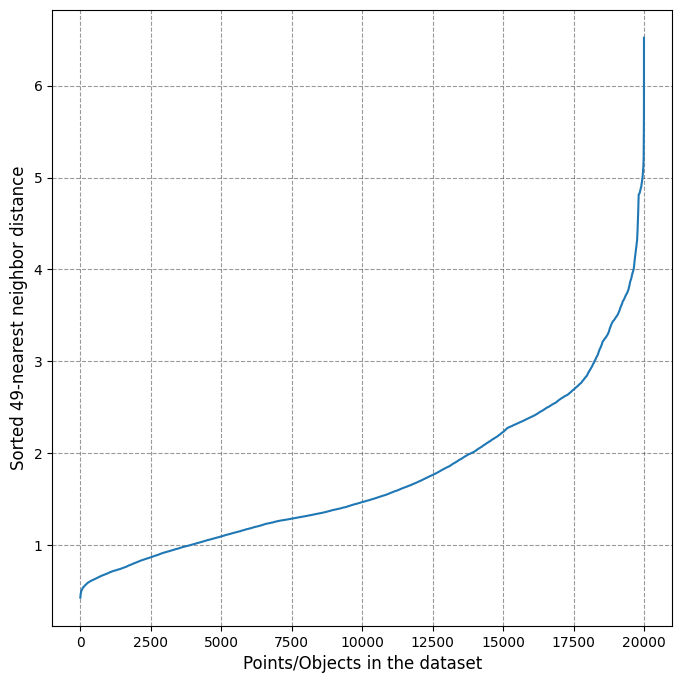

In [ ]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8, 8))
    plt.plot(distances)
    plt.xlabel("Points/Objects in the dataset", fontsize=12)
    plt.ylabel("Sorted {}-nearest neighbor distance".format(k), fontsize=12)
    plt.grid(True, linestyle="--", color="black", alpha=0.4)
    plt.show()
    plt.close()


pt = PowerTransformer(method="yeo-johnson", standardize = True)
## Sur les variables numériques : 
data_to_transform = data_numeric_reduced.to_numpy()
X_transformed = pt.fit_transform(data_to_transform)
k = 2 * X_transformed.shape[-1] - 1  # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_transformed, k=k)
## Sur toutes les variables
data_to_transform = data_tot_reduced.to_numpy()
X_transformed = pt.fit_transform(data_to_transform)
k = 2 * X_transformed.shape[-1] - 1  # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_transformed, k=k)

D'après ces courbes, la valeur optimale de eps est : 
- 0.05 pour data_numeric  
- 0.4 pour data_tot

#### DBSCAN sur data_numeric

# Variables numériques seules
Avec les paramètres choisis, DBSCAN a défini 7 clusters
Il y a 1.565% d'outliers
Density-based cluster validity : 0.15172944987245138


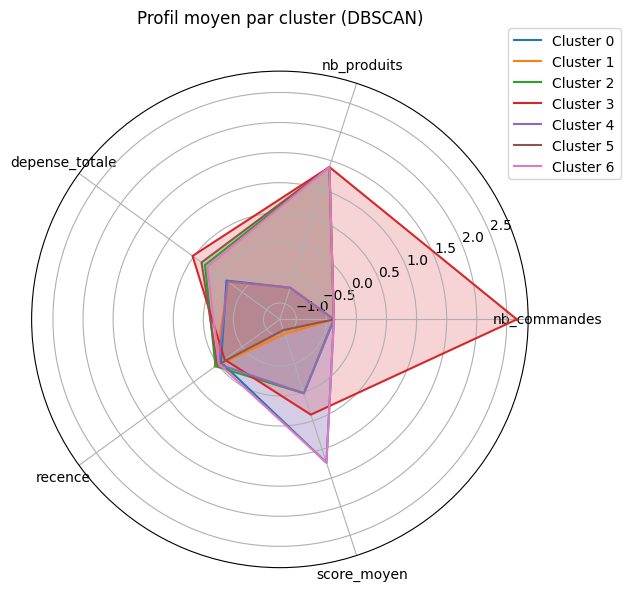

In [ ]:
prepare_compute_evaluate_dbscan(data = data_numeric_reduced, data_description = datasets_descriptions[1], eps = 0.4, min_samples = 2*len(data_numeric_reduced.columns), metric = "euclidean")

Avec ces valeurs de paramètres, le clustering n'est pas très bon et donne beaucoup de clusters difficiles à interpréter. On augmente donc eps afin de diminuer le nombre de clusters : 

# Variables numériques seules
Avec les paramètres choisis, DBSCAN a défini 3 clusters
Il y a 0.025% d'outliers
Density-based cluster validity : 0.45538575307347884


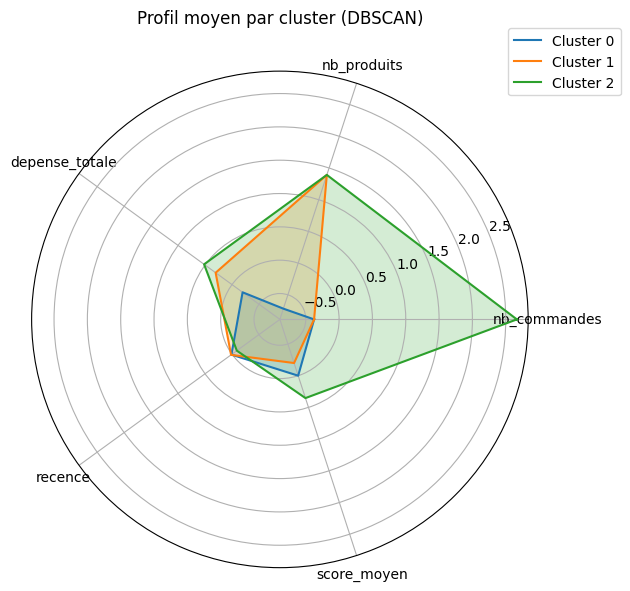

In [ ]:
prepare_compute_evaluate_dbscan(data = data_numeric_reduced, data_description = datasets_descriptions[1], eps = 0.8, min_samples = 2*len(data_numeric_reduced.columns), metric = "euclidean")

Les résultats sont plus faciles à interpréter, la quantité d'outliers est réduite et la métrique d'évaluation du clustering donne un meilleur résultat. 

#### DBSCAN sur data_tot

In [23]:
prepare_compute_evaluate_dbscan(data = data_tot_reduced, data_description = datasets_descriptions[-1], eps = 2.5, min_samples = 2*len(data_tot_reduced.columns), metric = 'euclidean')

# Variables numériques et catégorielles encodées
Avec les paramètres choisis, DBSCAN a défini 71 clusters
Il y a 6.875% d'outliers


Avec ces valeurs de paramètres, on obtient trop de clusters, ce qui empêche l'interprétation des résultats. On essaye donc d'augmenter eps pour limiter le nombre de clusters

# Variables numériques et catégorielles encodées
Avec les paramètres choisis, DBSCAN a défini 4 clusters
Il y a 0.0% d'outliers
Density-based cluster validity : 0.10410259013087371


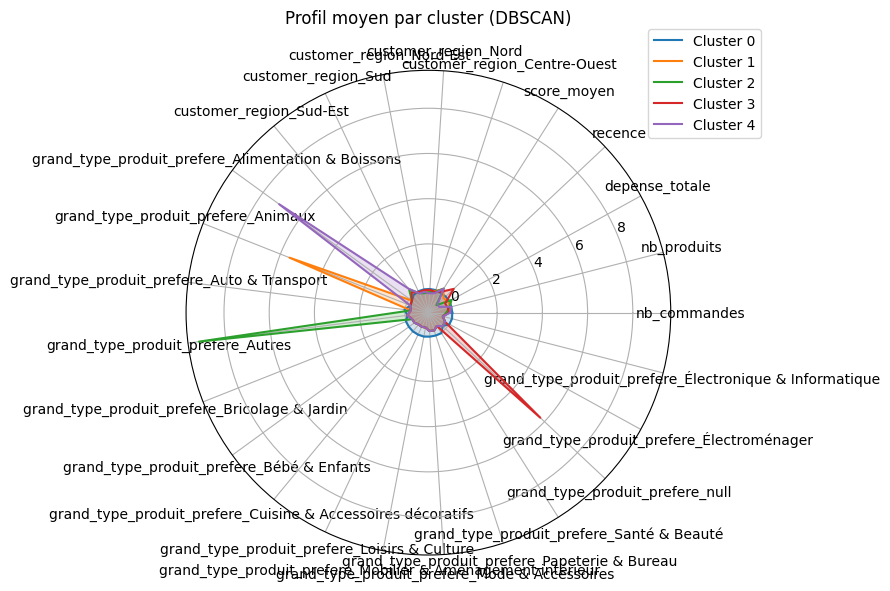

In [22]:
prepare_compute_evaluate_dbscan(data = data_tot_reduced, data_description = datasets_descriptions[-1], eps = 6, min_samples = 2*len(data_tot_reduced.columns), metric = 'euclidean')

Les variables catégorielles ont pris le dessus sur les autres. Ceci est dû au type de distance utilisée i.e. euclidienne. On essaye avec la métrique hamming : 

# Variables numériques et catégorielles encodées
Avec les paramètres choisis, DBSCAN a défini 5 clusters
Il y a 97.7% d'outliers
Density-based cluster validity : 0.6942982078204778


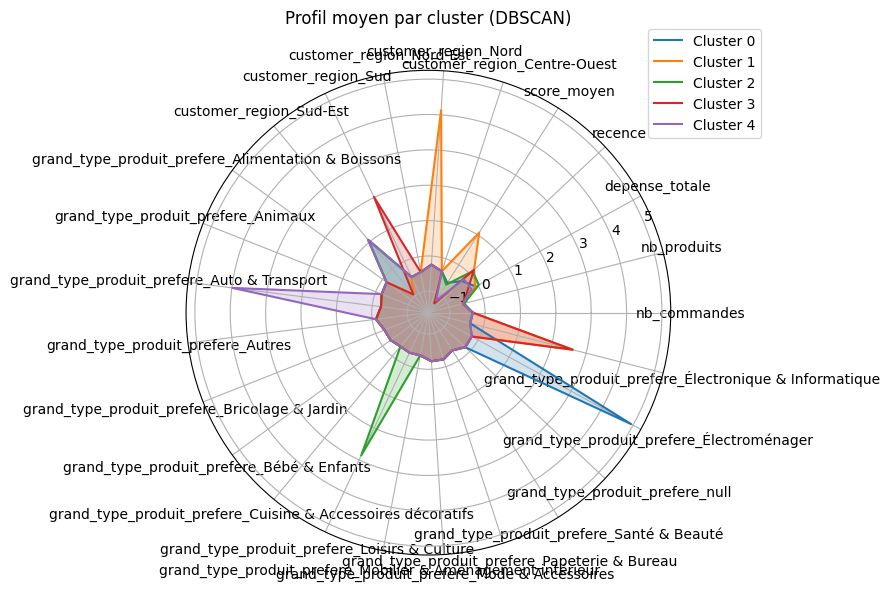

In [ ]:
prepare_compute_evaluate_dbscan(data = data_tot_reduced, data_description = datasets_descriptions[-1], eps = 0.1, min_samples = 2*len(data_tot_reduced.columns), metric = 'hamming')

Il y a trop d'outliers, c'est peut être dû au fait qu'on a fait un kmeans au préalable. 

# Clustering hiérarchique

Le clustering hiérarchique regroupe les points par similarité de manière progressive.
Il commence avec chaque point dans son propre cluster, puis fusionne les plus proches (approche agglomérative).
Le processus continue jusqu’à obtenir un seul cluster ou un nombre défini de clusters.
La proximité entre clusters peut être mesurée par différents critères (moyenne, minimum, Ward i.e. regrouppement entrainant la plus faible augmentation d'inertie).
Le résultat peut être visualisé sous forme de dendrogramme (arbre de fusions).
Il n’est pas nécessaire de définir le nombre de clusters à l’avance : on peut couper l’arbre à différents niveaux.
Peut créer des problèmes de mémoire RAM donc on fait un K means grossier en amont, afin de se ramener à 10 000 clusters (technique de réduction du nombre de lignes) 

In [ ]:
#Calcul des liaisons hiérarchiques
linkage_array = linkage(data_numeric_reduced, method="ward", metric = "euclidean")
print(linkage_array[:,:5])

[[5.78300000e+03 1.74880000e+04 1.84758490e-04 2.00000000e+00]
 [1.12500000e+03 1.95030000e+04 2.09471346e-04 2.00000000e+00]
 [7.90000000e+02 1.93680000e+04 2.13257036e-04 2.00000000e+00]
 ...
 [3.99900000e+04 3.99930000e+04 1.25621805e+02 7.54600000e+03]
 [3.99940000e+04 3.99960000e+04 1.62127086e+02 1.31860000e+04]
 [3.99950000e+04 3.99970000e+04 2.95388726e+02 2.00000000e+04]]


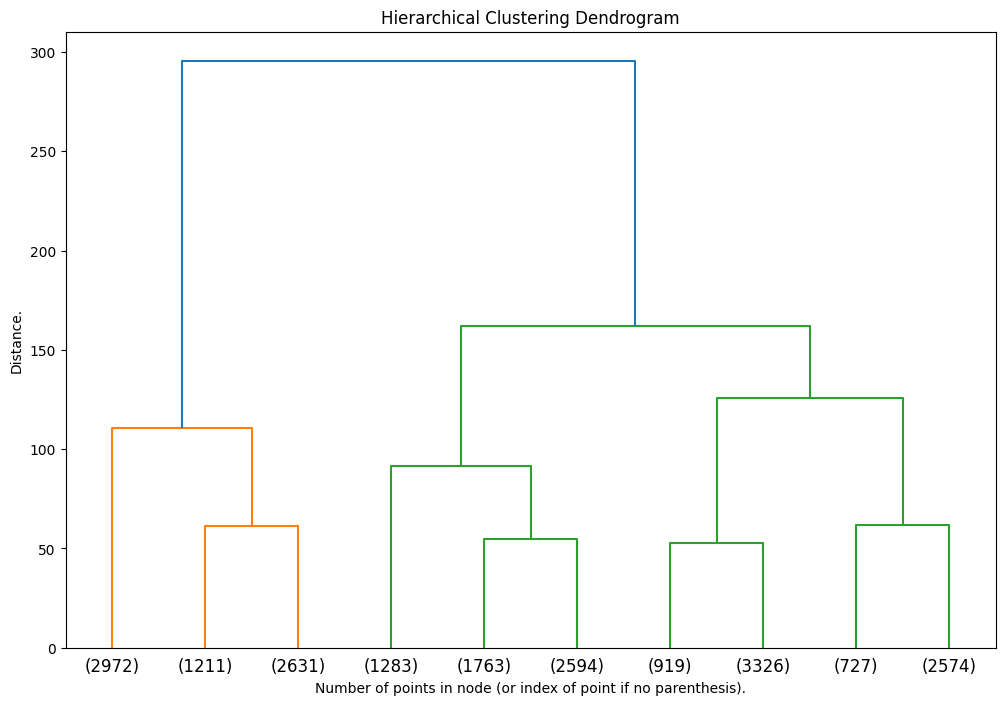

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dendrogram(linkage_array, p=10, truncate_mode="lastp", ax=ax)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [25]:
for cluster_thr in range(2, 11):
    labels = fcluster(linkage_array, cluster_thr, criterion="maxclust")
    silhouette_avg = silhouette_score(data_numeric_reduced.to_numpy(), labels)
    db_avg = davies_bouldin_score(data_numeric_reduced.to_numpy(), labels)
    print(f"--- POUR {cluster_thr} CLUSTERS --- \n Silhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}")

--- POUR 2 CLUSTERS --- 
 Silhouette : 0.47516156322732434 
Davies Bouldin : 0.9043870012208814
--- POUR 3 CLUSTERS --- 
 Silhouette : 0.38282474986700316 
Davies Bouldin : 1.0879812625980694
--- POUR 4 CLUSTERS --- 
 Silhouette : 0.4079448828594971 
Davies Bouldin : 0.8236684794201456
--- POUR 5 CLUSTERS --- 
 Silhouette : 0.3958062978830857 
Davies Bouldin : 0.891237298719209
--- POUR 6 CLUSTERS --- 
 Silhouette : 0.4050153443074844 
Davies Bouldin : 0.8316023964754898
--- POUR 7 CLUSTERS --- 
 Silhouette : 0.40139074048031004 
Davies Bouldin : 0.7649068152256735
--- POUR 8 CLUSTERS --- 
 Silhouette : 0.38771305158239777 
Davies Bouldin : 0.7917201486163652
--- POUR 9 CLUSTERS --- 
 Silhouette : 0.36416876751856564 
Davies Bouldin : 0.867901088561145
--- POUR 10 CLUSTERS --- 
 Silhouette : 0.3664255650401812 
Davies Bouldin : 0.8825908411297364


En prenant en compte à la fois l'interprétabilité et les résultats des métriques, il semble que c'est pour 4 clusters qu'on a les meilleurs résultats.

In [26]:
cluster_assignments = fcluster(linkage_array, 4, criterion="maxclust")

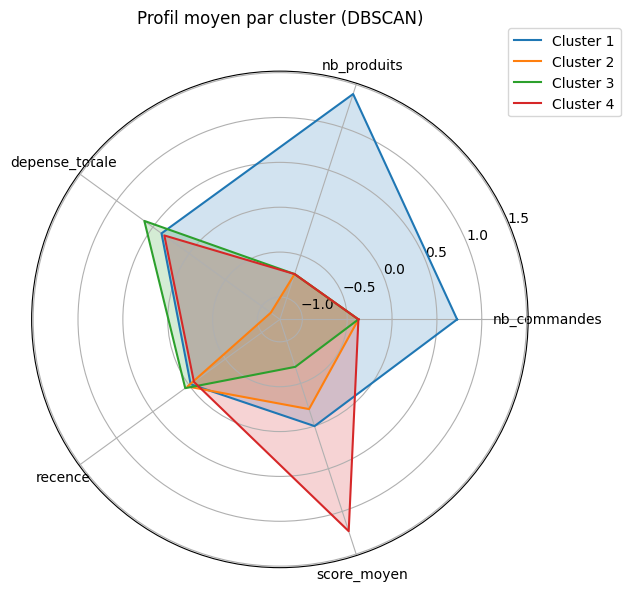

In [38]:
#scale data
X_transformed = data_numeric_reduced.to_numpy(allow_copy = True)
pt = PowerTransformer(method="yeo-johnson", standardize = True)
X_transformed = pt.fit_transform(X_transformed)

# Moyennes par cluster
unique_labels = np.unique(cluster_assignments)
cluster_means = []
for label in unique_labels:
    cluster_points = X_transformed[cluster_assignments == label]
    cluster_means.append(cluster_points.mean(axis=0))
cluster_means = np.array(cluster_means)

# Radar plot
num_vars = X_transformed.shape[1]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # fermeture du polygone


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, row in enumerate(cluster_means):
    row_closed = np.concatenate([row, [row[0]]])
    ax.plot(angles, row_closed, label=f"Cluster {unique_labels[i]}")
    ax.fill(angles, row_closed, alpha=0.2)

# Labels des axes
feature_labels = [f"{data.columns[i]}" for i in range(num_vars)]
angles_labels = angles[:-1]  # enlever l'angle du doublon
ax.set_xticks(angles_labels)
ax.set_xticklabels(feature_labels)

ax.set_title("Profil moyen par cluster (DBSCAN)", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

Critère de choix du modèle : l'interprétabilité et la stabilité. 

Clustering sur data_tot :

In [47]:
#Calcul des liaisons hiérarchiques
linkage_array = linkage(data_tot_reduced, metric = "hamming")
print(linkage_array[:,:5])

[[1.0866e+04 1.3853e+04 4.0000e-02 2.0000e+00]
 [2.0100e+02 3.5760e+03 4.0000e-02 2.0000e+00]
 [1.3150e+04 1.7836e+04 4.0000e-02 2.0000e+00]
 ...
 [1.2114e+04 3.9995e+04 4.8000e-01 1.9998e+04]
 [1.6035e+04 3.9996e+04 4.8000e-01 1.9999e+04]
 [6.8000e+01 3.9997e+04 5.2000e-01 2.0000e+04]]


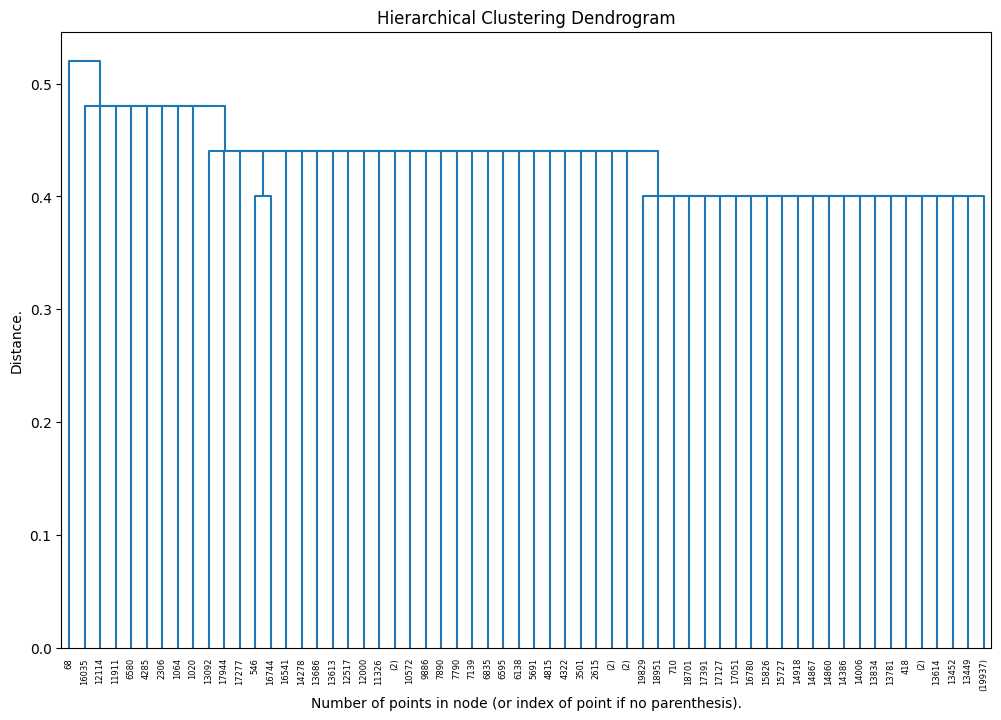

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dendrogram(linkage_array, p=60, truncate_mode="lastp", ax=ax)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [50]:
for cluster_thr in range(2, 11):
    labels = fcluster(linkage_array, cluster_thr, criterion="maxclust")
    silhouette_avg = silhouette_score(data_tot_reduced.to_numpy(), labels)
    db_avg = davies_bouldin_score(data_tot_reduced.to_numpy(), labels)
    print(f"--- POUR {cluster_thr} CLUSTERS --- \n Silhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}")

--- POUR 2 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 3 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 4 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 5 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 6 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 7 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 8 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 9 CLUSTERS --- 
 Silhouette : -0.16522106507908244 
Davies Bouldin : 1.4224632436878688
--- POUR 10 CLUSTERS --- 
 Silhouette : -0.361412517759798 
Davies Bouldin : 1.4218428871984101
--- POUR 11 CLUSTERS --- 
 Silhouette : -0.361412517759798 
Davies Bouldin : 1.4218428871984101
--- POUR 12 CLUSTERS --- 
 Silho

Avec les variables encodées, le clustering hiérarchique donne également de mauvais résultats, que ce soit avec la métrique "euclidean" ou "hamming"